# Importación de librerías

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import itertools
import matplotlib
from datetime import datetime 
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'
sns.set()

# 1. Forecast de ventas de vino

### 1.1 Exploración de datos

In [2]:
data = pd.read_csv(r'C:\Users\aleja\Desktop\Datoslab\Australianwines.csv')

In [3]:
data.head()

,Month,Fortified,Red,Rose,sparkling,Sweet white,Dry white
0,Jan-80,2585,464,112,1686,85,1954
1,Feb-80,3368,675,118,1591,89,2302
2,Mar-80,3210,703,129,2304,109,3054
3,Apr-80,3111,887,99,1712,95,2414
4,May-80,3756,1139,116,1471,91,2226


In [4]:
data.dtypes

Month          object
Fortified       int64
Red             int64
Rose           object
sparkling       int64
Sweet white     int64
Dry white       int64
dtype: object

**Observamos que la columna Rose, no es de tipo entero**

In [5]:
data['Rose ']

0      112
1      118
2      129
3       99
4      116
      ... 
175      *
176     46
177     51
178     63
179     84
Name: Rose , Length: 180, dtype: object

**Se intentará encontrar las filas que contengan valores erróneos.**

In [6]:
notInt = {}
for i, value in enumerate(data['Rose ']):
    try:
        int(value)
    except:
        notInt[i] = value
print('Filas que no contienen valores enteros y su respectivo valor: ' , notInt)

Filas que no contienen valores enteros y su respectivo valor:  {174: '*', 175: '*'}


In [7]:
data[170:180]

,Month,Fortified,Red,Rose,sparkling,Sweet white,Dry white
170,Mar-94,1965,2201,42,1720,187,3754
171,Apr-94,2659,2455,48,1725,279,3708
172,May-94,2354,2204,44,1674,193,3210
173,Jun-94,2592,2660,45,1693,227,3517
174,Jul-94,2714,3670,*,2031,225,3905
175,Aug-94,2294,2665,*,1495,205,3670
176,Sep-94,2416,2639,46,2968,259,4221
177,Oct-94,2016,2226,51,3385,254,4404
178,Nov-94,2799,2586,63,3729,275,5086
179,Dec-94,2467,2684,84,5999,394,5725


**Por ahora solo reemplazaremos estos valores por cero (evaluar si se eliminan las filas, o reemplazamos por promedio)**

In [8]:
data['Rose '][174] = 0
data['Rose '][175] = 0
data['Rose '] = data['Rose '].astype(int)

<ipython-input-8-91e622e93bc5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Rose '][174] = 0
<ipython-input-8-91e622e93bc5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [9]:
arr = [datetime(1980 + j, i + 1, 1)  for j in range(15) for i in range(12)]
data['Date'] = pd.DataFrame(arr, dtype = 'datetime64[ns]')

In [10]:
data = data.set_index('Date')

In [11]:
data.index

DatetimeIndex(['1980-01-01', '1980-02-01', '1980-03-01', '1980-04-01',
               '1980-05-01', '1980-06-01', '1980-07-01', '1980-08-01',
               '1980-09-01', '1980-10-01',
               ...
               '1994-03-01', '1994-04-01', '1994-05-01', '1994-06-01',
               '1994-07-01', '1994-08-01', '1994-09-01', '1994-10-01',
               '1994-11-01', '1994-12-01'],
              dtype='datetime64[ns]', name='Date', length=180, freq=None)

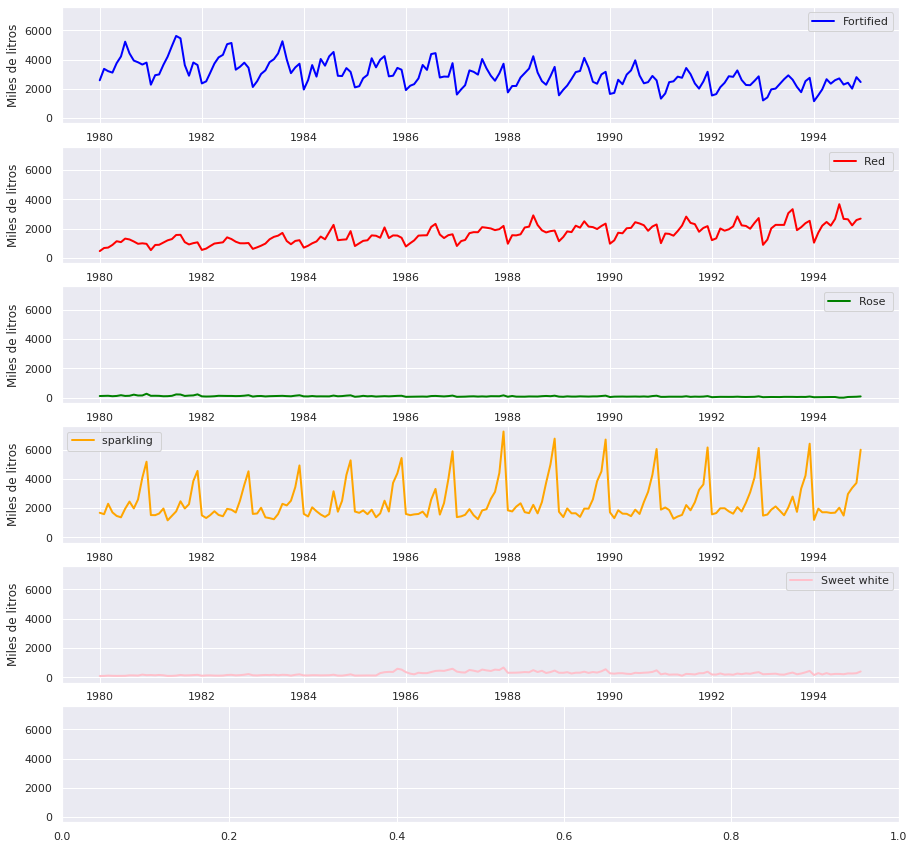

In [251]:
f, axes = plt.subplots(6, 1, sharey=True, figsize = (15,15))
colors = ['blue', 'red', 'green', 'orange', 'pink', 'purple']

for col, i, color in zip(data.columns[1:-1], range(6), colors):
    axes[i].plot(data[col], label = col, linewidth = 2, color = color)
    axes[i].legend()
    axes[i].set_xlabel('Año')
    axes[i].set_ylabel('Miles de litros')
plt.savefig('Series.pdf')

### 1.2 Seasonal descompose


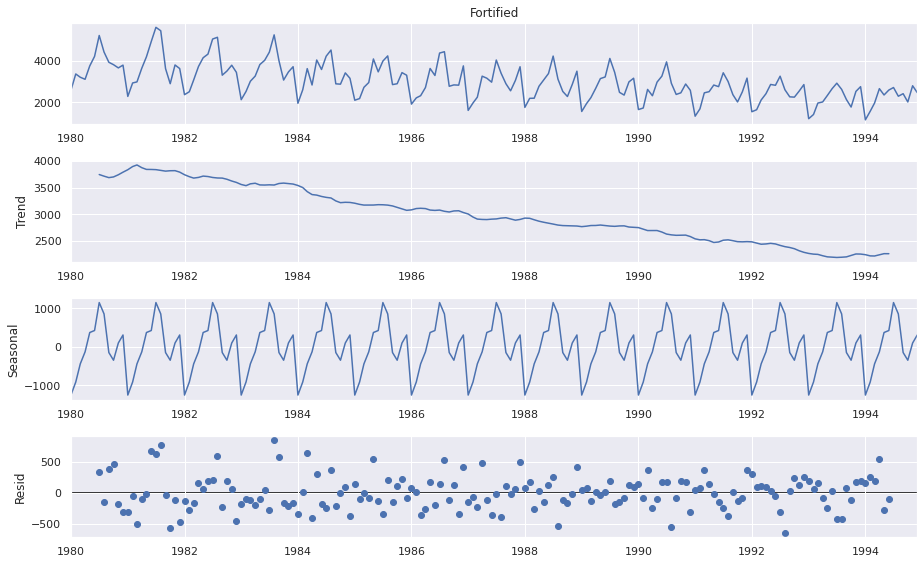

In [260]:
from pylab import rcParams
rcParams['figure.figsize'] = 13, 8
decomposition = sm.tsa.seasonal_decompose(data['Fortified'], model='additive', period = 12)
fig = decomposition.plot()
plt.show()
fig.savefig('seasonal_descompose.png')

### 1.3 Sarimax


In [14]:
train  = data[:126]
validacion = data[126:]

In [15]:

def sarimax_results(serie_name = 'Fortified', train_data = train, val_data = validacion):
    predictions = []
    confidence = []
    
    dates = val_data.index
    mod = sm.tsa.statespace.SARIMAX(train_data[serie_name],
                                    order=(1, 1, 1),
                                    seasonal_order=(1, 1, 1, 2),
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)
    model_fit = mod.fit()
    train_pred = model_fit.predict(0,125)
    for date1, date2 in zip(dates[0::2], dates[1::2]):
        yhat = model_fit.get_prediction(start= date1, end = date2)
        confidence.append(yhat.conf_int())
        predictions.extend(yhat.predicted_mean)
        
        model_fit = model_fit.extend(val_data[date1:date2][serie_name])
        
    return pd.DataFrame(predictions, index = dates,columns = ['Prediccion validación']), model_fit, confidence, train_pred
 

In [16]:
def plot_results(pred, conf, train_predict, serie_name): 
    ax = pred.plot(figsize = (15,6))
    data[serie_name].plot(ax= ax, label = 'Real')

    upper= []
    lower = []
    idxs = []
    for value in conf:
        idx, y1, y2 = (value.index, value.iloc[:, 0], value.iloc[:, 1])
        upper.extend(y1)
        lower.extend(y2)
        idxs.extend(idx)

    ax.fill_between(x = idxs,
                    y1 = upper,
                    y2 = lower, color='k', alpha=.2)

    ax.set_xlabel('Fecha')
    ax.set_ylabel('Miles de litros')
    ax.set_title('Ventas de vino ' + serie_name.upper())
    train_predict.plot(ax = ax, label = 'Predicción entrenamiento')
    plt.legend()
    plt.show()
    fig = ax.get_figure()
    fig.savefig(serie_name + '.pdf')

In [17]:
def get_rmse(pred, serie_name):
    
    mse = ((np.asarray(pred).reshape(len(pred))- np.asarray(validacion[serie_name]))**2).mean()
    rmse = round(np.sqrt(mse),2)
    return round(mse,2), rmse

def get_rmse_train(train_predict, serie_name):
    mse = ((np.asarray(train_predict).reshape(len(train_predict))- np.asarray(train[serie_name]))**2).mean()
    
    rmse = round(np.sqrt(mse),2)
    return round(mse,2), rmse

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


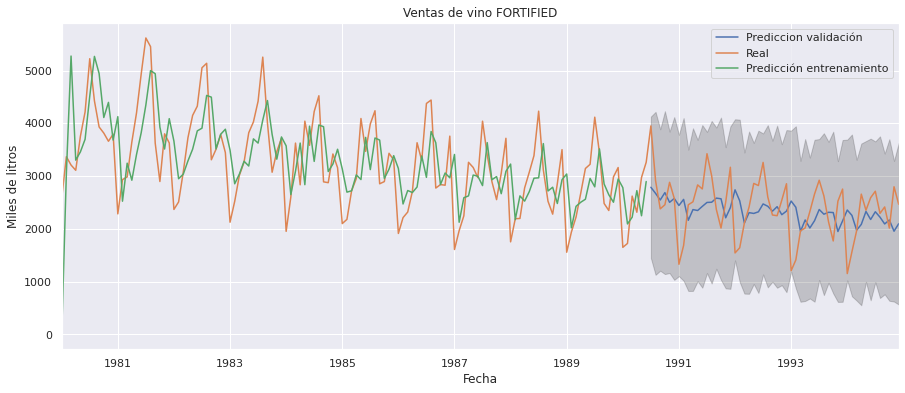

In [261]:
serie_name = 'Fortified' 
pred, model, conf, train_predict = sarimax_results(serie_name)
plot_results(pred, conf, train_predict, serie_name)

In [262]:
mse, rmse = get_rmse(pred, serie_name)
print('MSE: {}'. format(mse))
print('RMSE: {}'. format(rmse))

MSE: 336366.15
RMSE: 579.97


In [263]:
mse, rmse = get_rmse_train(train_predict, serie_name)
print('MSE: {}'. format(mse))
print('RMSE: {}'. format(rmse))

MSE: 584117.35
RMSE: 764.28


In [264]:
errores = np.abs((np.array(pred).reshape(len(pred))-np.array(validacion[serie_name])))
errores = pd.DataFrame(errores)

In [268]:
print(errores.quantile(0.1))

0    71.591246
Name: 0.1, dtype: float64


In [269]:
print(errores.quantile(0.9))

0    975.851657
Name: 0.9, dtype: float64


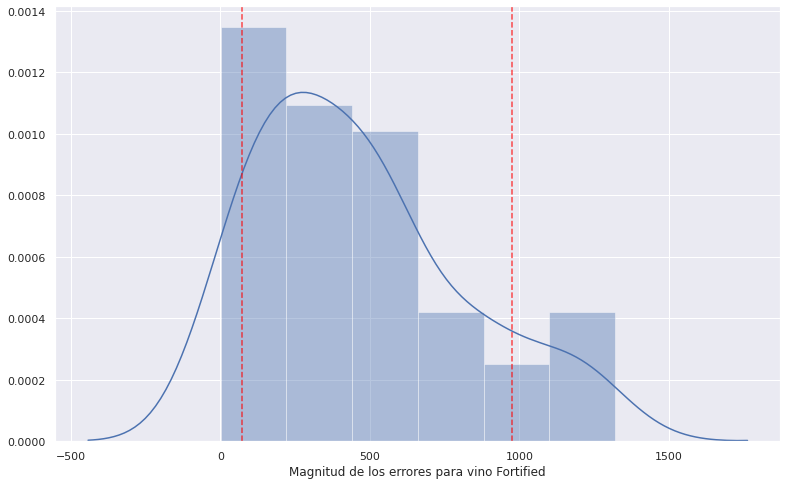

In [266]:
sns.distplot(errores, axlabel = 'Magnitud de los errores para vino '+ serie_name)
plt.axvline(errores.quantile(0.1)[0], color = 'red', linestyle = '--', alpha = 0.7)
plt.axvline(errores.quantile(0.9)[0], color = 'red', linestyle = '--', alpha = 0.7)
plt.savefig('hist'+ serie_name+'pdf')

## 1.4 MA con diferenciación

2.9 Usar la diferenciación para eliminar la tendencia y / o la estacionalidad de cada serie para
que luego podamos usar un promedio móvil para pronosticar las ventas futuras.

2.10 Escribir sobre las operaciones de diferenciación que aplicó a cada una de las seis
series, explicando por qué eligió esas operaciones. Incluir gráficos puede ayudar a respaldar
sus argumentos.

2.11 Predicción de ventas de vinos utilizando un MA: Use un promedio móvil con un
ancho de ventana de 12 (MA (12)) para pronosticar las ventas con doble diferencia de las
ventas de vino fortificado en febrero de 1995.

2.12 Finalmente, ajuste el pronóstico "sin diferenciar" dos veces, para incluir de nuevo la
tendencia y la estacionalidad. Reportar su pronóstico final para las ventas de vinos
fortificados en febrero de 1995 utilizando este método. Discuta cualquier desafío o pregunta
que haya encontrado

In [270]:
serie = 'Fortified'

def diferenciacion(serie):
    dif = train[serie] - train[serie].shift()    
    dif2 = dif.fillna(0) - dif.fillna(0).shift()
    dif_val = validacion[serie] - validacion[serie].shift()    
    dif2_val = dif_val.fillna(0) - dif_val.fillna(0).shift()
    
    
    return dif2, dif2_val

In [271]:
from statsmodels.tsa.arima.model import ARIMA
def ma_results(serie_name = 'Fortified', dif = True):
    predictions = []
    confidence = []
    if dif:
        train_data, val_data = diferenciacion(serie)
    else:
        train_data, val_data = train[serie], validacion[serie]
    dates = val_data.index
    mod = ARIMA(train_data, order=(0, 0, 12))
    
    model_fit = mod.fit()
    train_pred = model_fit.predict(0,125)
    for date1, date2 in zip(dates[0::2], dates[1::2]):
        yhat = model_fit.get_prediction(start= date1, end = date2)
        confidence.append(yhat.conf_int())
        predictions.extend(yhat.predicted_mean)
        
        model_fit = model_fit.extend(val_data[date1:date2])
        
    return pd.DataFrame(predictions, index = dates,columns = ['Prediccion validación']), model_fit, confidence, train_pred
 

In [272]:
pred, modl, confidence, pred_train =  ma_results(serie)
dif2_train, dif2_val = diferenciacion(serie)

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimizati

In [273]:
date1 = pd.datetime(1995, 1, 1) #enero
date2 = pd.datetime(1995, 2, 1) #febrero

<ipython-input-273-0347d65d625b>:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  date1 = pd.datetime(1995, 1, 1)
<ipython-input-273-0347d65d625b>:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  date2 = pd.datetime(1995, 2, 1)


In [165]:
#Predicciones para enero y febrero 1995
predictions = modl.get_prediction(start= date1, end = date2).predicted_mean

#Recuperamos los valores haciendo "des-diferenciacion"
enero = predictions[0] - validacion[serie][-2]+ 2*validacion[serie][-1]
febrero = predictions[1] - validacion[serie][-1] + 2*enero

y_hat_dif2 = pd.DataFrame([validacion[serie][-1],enero, febrero],columns = ['Predicción con diferenciación'], index = validacion.index[-1:].append(predictions.index))

### Sin diferenciacion

In [167]:
pred, modl, confidence, pred_train =  ma_results(serie, dif = False)


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


In [168]:
[enero, febrero] = modl.get_prediction(start= date1, end = date2).predicted_mean
y_hat = pd.DataFrame([validacion[serie][-1],enero, febrero],columns = ['Predicción sin diferenciación'], index = validacion.index[-1:].append(predictions.index))

<ipython-input-184-9b1917e58521>:5: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  ax.set_xlim((pd.datetime(1980,1,1), pd.datetime(1995,5,1)))


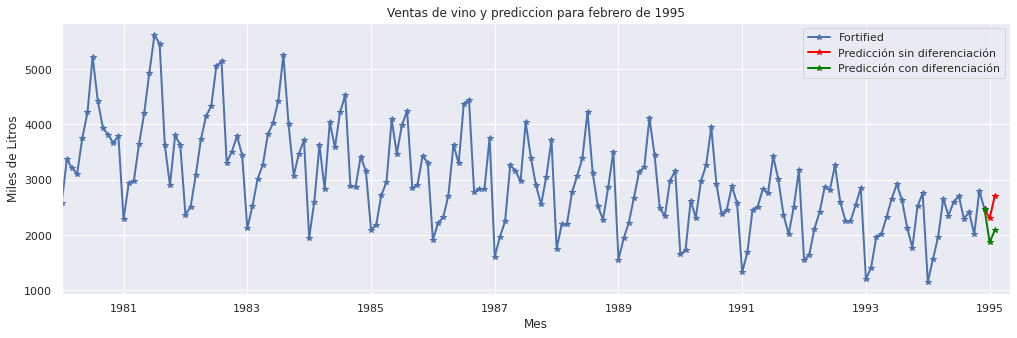

In [184]:
ax = data[serie].plot(figsize = (17,5), marker = '*', linewidth =2)
y_hat.plot(ax = ax, marker = '*', linewidth = 2, color = 'red')
y_hat_dif2.plot(ax = ax, marker = '*', linewidth = 2, color = 'green')

ax.set_xlim((pd.datetime(1980,1,1), pd.datetime(1995,5,1)))
ax.set_xlabel('Mes')
ax.set_ylabel('Miles de Litros')
ax.set_title('Ventas de vino y prediccion para febrero de 1995')
plt.legend()
fig = ax.get_figure()
fig.savefig(serie + '_dif.pdf')


## Modelo Machine Learning

In [10]:
data['Rose '][174] = 92
data['Rose '][175] = 92
data['Rose '] = data['Rose '].astype(int)

B:\Anaconda\envs\hola\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
B:\Anaconda\envs\hola\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [11]:
data['Month']=pd.to_datetime(data['Month'])

In [12]:
data.set_index('Month', inplace=True)

In [100]:
dfF=data.drop(['Red ','Rose ','sparkling ' ,'Sweet white','Dry white'], axis=1)
dfRed=data.drop(['Fortified','Rose ','sparkling ' ,'Sweet white','Dry white'], axis=1)
dfRose=data.drop(['Fortified','Red ','sparkling ' ,'Sweet white','Dry white'], axis=1)
dfSpar=data.drop(['Fortified','Red ','Rose ' ,'Sweet white','Dry white'], axis=1)
dfSweet=data.drop(['Fortified','Red ','sparkling ' ,'Rose ','Dry white'], axis=1)
dfDry=data.drop(['Fortified','Red ','sparkling ' ,'Sweet white','Rose '], axis=1)

In [102]:
dfRose

,Rose
Month,
1980-01-01,112
1980-02-01,118
1980-03-01,129
1980-04-01,99
1980-05-01,116
...,...
1994-08-01,0
1994-09-01,46
1994-10-01,51


In [21]:
import math
import keras
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

Using TensorFlow backend.


In [143]:
dataset = dfF.values
#Get /Compute the number of rows to train the model on
training_data_len = math.ceil( len(dataset) *.7) 
#Scale the all of the data to be values between 0 and 1 
scaler = MinMaxScaler(feature_range=(0, 1)) 
scaled_data = scaler.fit_transform(dataset)
#Create the scaled training data set 
train_data = scaled_data[0:training_data_len  , : ]
#Split the data into x_train and y_train data sets
x_train=[]
y_train = []
for i in range(12,len(train_data)):
    x_train.append(train_data[i-12:i,0])
    y_train.append(train_data[i,0])
    

#Convert x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)
#Reshape the data into the shape accepted by the LSTM
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))
#Build the LSTM network model
model = Sequential()
model.add(Bidirectional(LSTM(units=50, return_sequences=True,input_shape=(x_train.shape[1],1))))
model.add(Bidirectional(LSTM(units=50, return_sequences=False)))
model.add(Dense(units=25))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [144]:
model.fit(x_train, y_train, batch_size=1, epochs=20)

Epoch 1/20
114/114 [==============================] - 31s 276ms/step - loss: 0.0482
Epoch 2/20
114/114 [==============================] - 8s 74ms/step - loss: 0.0228
Epoch 3/20
114/114 [==============================] - ETA: 0s - loss: 0.016 - 9s 77ms/step - loss: 0.0161
Epoch 4/20
114/114 [==============================] - 8s 72ms/step - loss: 0.0128
Epoch 5/20
114/114 [==============================] - 8s 72ms/step - loss: 0.0109
Epoch 6/20
114/114 [==============================] - 8s 69ms/step - loss: 0.0130: 0s - l
Epoch 7/20
114/114 [==============================] - 7s 64ms/step - loss: 0.0120
Epoch 8/20
114/114 [==============================] - 7s 60ms/step - loss: 0.0084
Epoch 9/20
114/114 [==============================] - 9s 77ms/step - loss: 0.0103
Epoch 10/20
114/114 [==============================] - 7s 60ms/step - loss: 0.0096
Epoch 11/20
114/114 [==============================] - 7s 66ms/step - loss: 0.0081
Epoch 12/20
114/114 [==============================] - 7s 62ms

In [145]:
#Test data set
test_data = scaled_data[training_data_len - 12: , : ]
#Create the x_test and y_test data sets
x_test = []
y_test =  dataset[training_data_len : , : ] #Get all of the rows from index 1603 to the rest and all of the columns (in this case it's only column 'Close'), so 2003 - 1603 = 400 rows of data
for i in range(12,len(test_data)):
    x_test.append(test_data[i-12:i,0])
    

In [146]:
#Convert x_test to a numpy array 
x_test = np.array(x_test)
#Reshape the data into the shape accepted by the LSTM
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))
#Getting the models predicted price values
predictions = model.predict(x_test) 
predictions = scaler.inverse_transform(predictions)#Undo scaling
#Calculate/Get the value of RMSE
rmse=np.sqrt(np.mean(((predictions- y_test)**2)))
rmse

264.3082901449673

B:\Anaconda\envs\hola\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


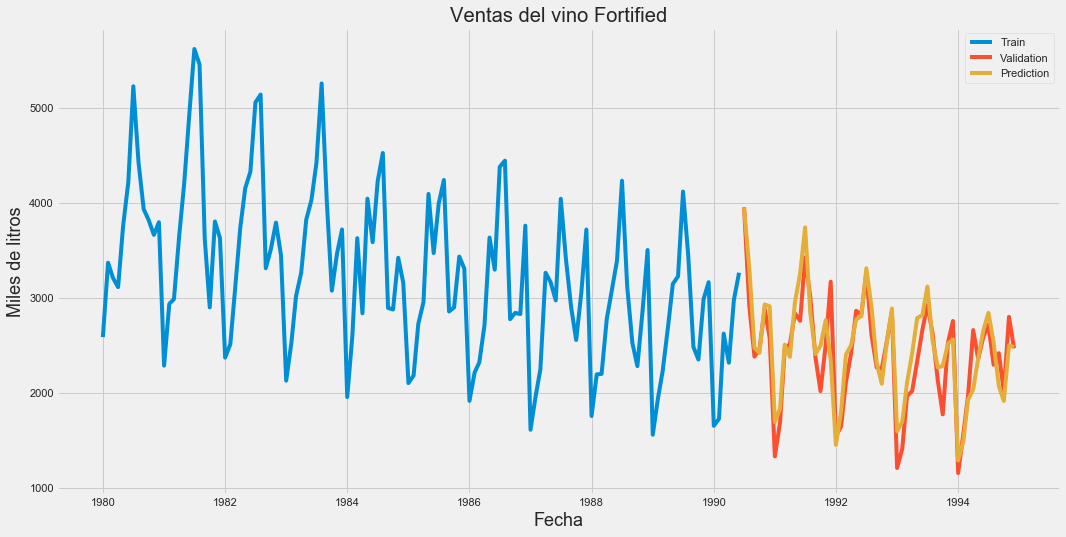

In [147]:
#Plot/Create the data for the graph
train = dfF[:training_data_len]
valid = dfF[training_data_len:]
valid['Predictions'] = predictions
#Visualize the data
plt.figure(figsize=(16,8))
plt.title('Ventas del vino Fortified')
plt.xlabel('Fecha', fontsize=18)
plt.ylabel('Miles de litros', fontsize=18)
plt.plot(train['Fortified'])
plt.plot(valid[['Fortified', 'Predictions']])
plt.legend(['Train', 'Validation', 'Prediction'], loc='upper right')
plt.show()

In [138]:
dataset = dfRed.values
#Get /Compute the number of rows to train the model on
training_data_len = math.ceil( len(dataset) *.7) 
#Scale the all of the data to be values between 0 and 1 
scaler = MinMaxScaler(feature_range=(0, 1)) 
scaled_data = scaler.fit_transform(dataset)
#Create the scaled training data set 
train_data = scaled_data[0:training_data_len  , : ]
#Split the data into x_train and y_train data sets
x_train=[]
y_train = []
for i in range(12,len(train_data)):
    x_train.append(train_data[i-12:i,0])
    y_train.append(train_data[i,0])
    

#Convert x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)
#Reshape the data into the shape accepted by the LSTM
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))
#Build the LSTM network model
model = Sequential()
model.add(Bidirectional(LSTM(units=50, return_sequences=True,input_shape=(x_train.shape[1],1))))
model.add(Bidirectional(LSTM(units=50, return_sequences=False)))
model.add(Dense(units=25))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [139]:
model.fit(x_train, y_train, batch_size=1, epochs=20)

Epoch 1/20
114/114 [==============================] - 26s 226ms/step - loss: 0.0204
Epoch 2/20
114/114 [==============================] - 7s 65ms/step - loss: 0.0125
Epoch 3/20
114/114 [==============================] - 7s 62ms/step - loss: 0.0114
Epoch 4/20
114/114 [==============================] - 8s 70ms/step - loss: 0.0071
Epoch 5/20
114/114 [==============================] - 7s 63ms/step - loss: 0.0068
Epoch 6/20
114/114 [==============================] - 7s 65ms/step - loss: 0.0067
Epoch 7/20
114/114 [==============================] - 7s 62ms/step - loss: 0.0073
Epoch 8/20
114/114 [==============================] - 7s 62ms/step - loss: 0.0072
Epoch 9/20
114/114 [==============================] - 7s 62ms/step - loss: 0.0063
Epoch 10/20
114/114 [==============================] - 7s 62ms/step - loss: 0.0060
Epoch 11/20
114/114 [==============================] - 7s 63ms/step - loss: 0.0062
Epoch 12/20
114/114 [==============================] - 7s 61ms/step - loss: 0.0059
Epoch 13/20

In [140]:
#Test data set
test_data = scaled_data[training_data_len - 12: , : ]
#Create the x_test and y_test data sets
x_test = []
y_test =  dataset[training_data_len : , : ] #Get all of the rows from index 1603 to the rest and all of the columns (in this case it's only column 'Close'), so 2003 - 1603 = 400 rows of data
for i in range(12,len(test_data)):
    x_test.append(test_data[i-12:i,0])

In [141]:
#Convert x_test to a numpy array 
x_test = np.array(x_test)
#Reshape the data into the shape accepted by the LSTM
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))
#Getting the models predicted price values
predictions = model.predict(x_test) 
predictions = scaler.inverse_transform(predictions)#Undo scaling
#Calculate/Get the value of RMSE
rmse=np.sqrt(np.mean(((predictions- y_test)**2)))
rmse

423.0033053801357

B:\Anaconda\envs\hola\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


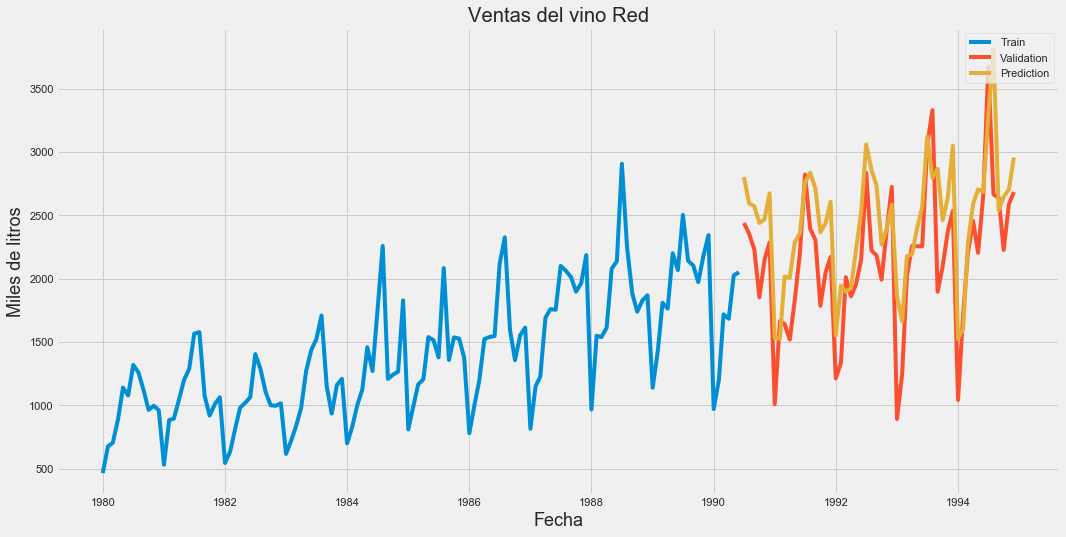

In [142]:
#Plot/Create the data for the graph
train = dfRed[:training_data_len]
valid = dfRed[training_data_len:]
valid['Predictions'] = predictions
#Visualize the data
plt.figure(figsize=(16,8))
plt.title('Ventas del vino Red')
plt.xlabel('Fecha', fontsize=18)
plt.ylabel('Miles de litros', fontsize=18)
plt.plot(train['Red '])
plt.plot(valid[['Red ', 'Predictions']])
plt.legend(['Train', 'Validation', 'Prediction'], loc='upper right')
plt.show()

In [133]:
dataset = dfRose.values
#Get /Compute the number of rows to train the model on
training_data_len = math.ceil( len(dataset) *.7) 
#Scale the all of the data to be values between 0 and 1 
scaler = MinMaxScaler(feature_range=(0, 1)) 
scaled_data = scaler.fit_transform(dataset)
#Create the scaled training data set 
train_data = scaled_data[0:training_data_len  , : ]
#Split the data into x_train and y_train data sets
x_train=[]
y_train = []
for i in range(12,len(train_data)):
    x_train.append(train_data[i-12:i,0])
    y_train.append(train_data[i,0])
    

#Convert x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)
#Reshape the data into the shape accepted by the LSTM
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))
#Build the LSTM network model
model = Sequential()
model.add(Bidirectional(LSTM(units=50, return_sequences=True,input_shape=(x_train.shape[1],1))))
model.add(Bidirectional(LSTM(units=50, return_sequences=False)))
model.add(Dense(units=25))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [134]:
model.fit(x_train, y_train, batch_size=1, epochs=20)

Epoch 1/20
114/114 [==============================] - 28s 246ms/step - loss: 0.0185
Epoch 2/20
114/114 [==============================] - 10s 86ms/step - loss: 0.0130
Epoch 3/20
114/114 [==============================] - 8s 74ms/step - loss: 0.0118
Epoch 4/20
114/114 [==============================] - 8s 74ms/step - loss: 0.0153
Epoch 5/20
114/114 [==============================] - 7s 62ms/step - loss: 0.0110
Epoch 6/20
114/114 [==============================] - 7s 62ms/step - loss: 0.0104
Epoch 7/20
114/114 [==============================] - 7s 63ms/step - loss: 0.0101
Epoch 8/20
114/114 [==============================] - 7s 61ms/step - loss: 0.0117
Epoch 9/20
114/114 [==============================] - 7s 65ms/step - loss: 0.0092
Epoch 10/20
114/114 [==============================] - 7s 64ms/step - loss: 0.0090
Epoch 11/20
114/114 [==============================] - 8s 66ms/step - loss: 0.0093
Epoch 12/20
114/114 [==============================] - 7s 64ms/step - loss: 0.0092
Epoch 13/2

In [135]:
#Test data set
test_data = scaled_data[training_data_len - 12: , : ]
#Create the x_test and y_test data sets
x_test = []
y_test =  dataset[training_data_len : , : ] #Get all of the rows from index 1603 to the rest and all of the columns (in this case it's only column 'Close'), so 2003 - 1603 = 400 rows of data
for i in range(12,len(test_data)):
    x_test.append(test_data[i-12:i,0])

In [136]:
#Convert x_test to a numpy array 
x_test = np.array(x_test)
#Reshape the data into the shape accepted by the LSTM
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))
#Getting the models predicted price values
predictions = model.predict(x_test) 
predictions = scaler.inverse_transform(predictions)#Undo scaling
#Calculate/Get the value of RMSE
rmse=np.sqrt(np.mean(((predictions- y_test)**2)))
rmse

22.48260404611388

B:\Anaconda\envs\hola\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


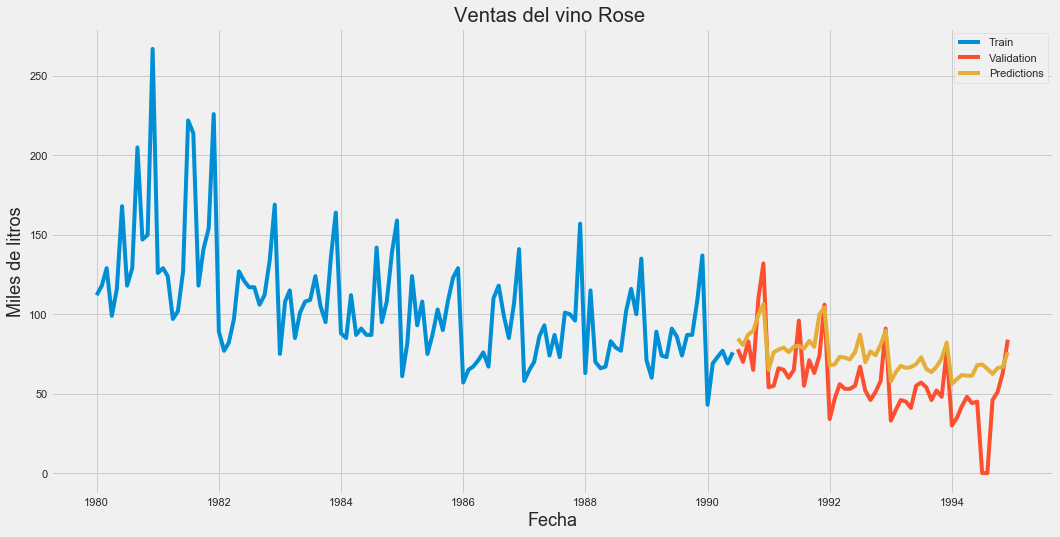

In [137]:
#Plot/Create the data for the graph
train = dfRose[:training_data_len]
valid = dfRose[training_data_len:]
valid['Predictions'] = predictions
#Visualize the data
plt.figure(figsize=(16,8))
plt.title('Ventas del vino Rose ')
plt.xlabel('Fecha', fontsize=18)
plt.ylabel('Miles de litros', fontsize=18)
plt.plot(train['Rose '])
plt.plot(valid[['Rose ', 'Predictions']])
plt.legend(['Train', 'Validation', 'Predictions'], loc='upper right')
plt.show()

In [127]:
dataset = dfSpar.values
#Get /Compute the number of rows to train the model on
training_data_len = math.ceil( len(dataset) *.7) 
#Scale the all of the data to be values between 0 and 1 
scaler = MinMaxScaler(feature_range=(0, 1)) 
scaled_data = scaler.fit_transform(dataset)
#Create the scaled training data set 
train_data = scaled_data[0:training_data_len  , : ]
#Split the data into x_train and y_train data sets
x_train=[]
y_train = []
for i in range(12,len(train_data)):
    x_train.append(train_data[i-12:i,0])
    y_train.append(train_data[i,0])
    

#Convert x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)
#Reshape the data into the shape accepted by the LSTM
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))
#Build the LSTM network model
model = Sequential()
model.add(Bidirectional(LSTM(units=50, return_sequences=True,input_shape=(x_train.shape[1],1))))
model.add(Bidirectional(LSTM(units=50, return_sequences=False)))
model.add(Dense(units=25))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [128]:
model.fit(x_train, y_train, batch_size=1, epochs=20)

Epoch 1/20
114/114 [==============================] - 26s 227ms/step - loss: 0.0385
Epoch 2/20
114/114 [==============================] - 7s 65ms/step - loss: 0.0172
Epoch 3/20
114/114 [==============================] - 7s 65ms/step - loss: 0.0117
Epoch 4/20
114/114 [==============================] - 8s 70ms/step - loss: 0.0083
Epoch 5/20
114/114 [==============================] - 7s 64ms/step - loss: 0.0063
Epoch 6/20
114/114 [==============================] - 7s 63ms/step - loss: 0.0075
Epoch 7/20
114/114 [==============================] - 8s 72ms/step - loss: 0.0067
Epoch 8/20
114/114 [==============================] - 7s 64ms/step - loss: 0.0061
Epoch 9/20
114/114 [==============================] - 8s 67ms/step - loss: 0.0062
Epoch 10/20
114/114 [==============================] - 8s 67ms/step - loss: 0.0064
Epoch 11/20
114/114 [==============================] - 7s 64ms/step - loss: 0.0072
Epoch 12/20
114/114 [==============================] - 7s 63ms/step - loss: 0.0058
Epoch 13/20

In [129]:
#Test data set
test_data = scaled_data[training_data_len - 12: , : ]
#Create the x_test and y_test data sets
x_test = []
y_test =  dataset[training_data_len : , : ] #Get all of the rows from index 1603 to the rest and all of the columns (in this case it's only column 'Close'), so 2003 - 1603 = 400 rows of data
for i in range(12,len(test_data)):
    x_test.append(test_data[i-12:i,0])

In [130]:
#Convert x_test to a numpy array 
x_test = np.array(x_test)
#Reshape the data into the shape accepted by the LSTM
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))
#Getting the models predicted price values
predictions = model.predict(x_test) 
predictions = scaler.inverse_transform(predictions)#Undo scaling
#Calculate/Get the value of RMSE
rmse=np.sqrt(np.mean(((predictions- y_test)**2)))
rmse

499.6812398812391

B:\Anaconda\envs\hola\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


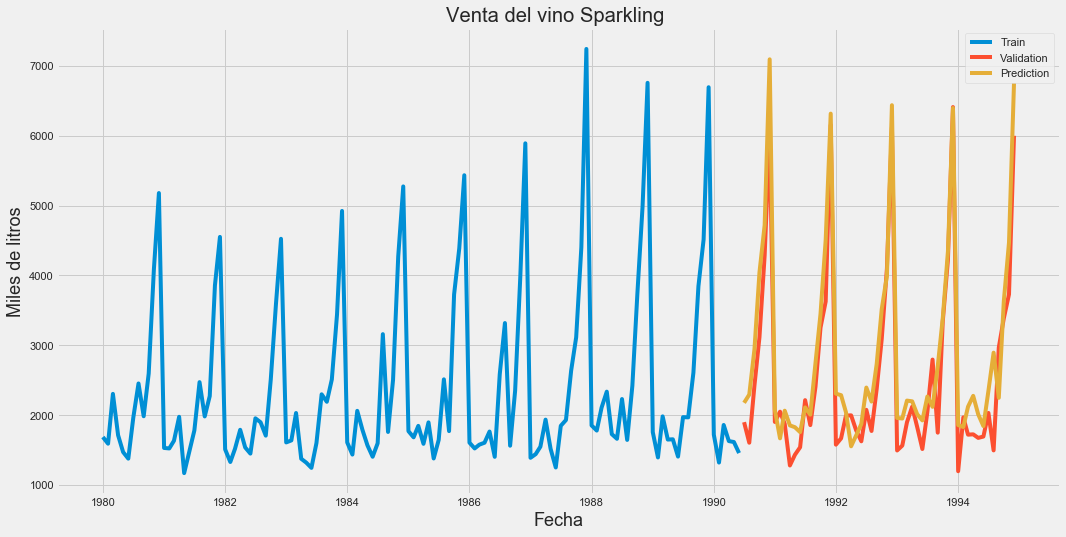

In [132]:
#Plot/Create the data for the graph
train = dfSpar[:training_data_len]
valid = dfSpar[training_data_len:]
valid['Predictions'] = predictions
#Visualize the data
plt.figure(figsize=(16,8))
plt.title('Venta del vino Sparkling ')
plt.xlabel('Fecha', fontsize=18)
plt.ylabel('Miles de litros', fontsize=18)
plt.plot(train['sparkling '])
plt.plot(valid[['sparkling ', 'Predictions']])
plt.legend(['Train', 'Validation', 'Prediction'], loc='upper right')
plt.show()

In [122]:
dataset = dfSweet.values
#Get /Compute the number of rows to train the model on
training_data_len = math.ceil( len(dataset) *.7) 
#Scale the all of the data to be values between 0 and 1 
scaler = MinMaxScaler(feature_range=(0, 1)) 
scaled_data = scaler.fit_transform(dataset)
#Create the scaled training data set 
train_data = scaled_data[0:training_data_len  , : ]
#Split the data into x_train and y_train data sets
x_train=[]
y_train = []
for i in range(12,len(train_data)):
    x_train.append(train_data[i-12:i,0])
    y_train.append(train_data[i,0])
    

#Convert x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)
#Reshape the data into the shape accepted by the LSTM
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))
#Build the LSTM network model
model = Sequential()
model.add(Bidirectional(LSTM(units=50, return_sequences=True,input_shape=(x_train.shape[1],1))))
model.add(Bidirectional(LSTM(units=50, return_sequences=False)))
model.add(Dense(units=25))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [123]:
model.fit(x_train, y_train, batch_size=1, epochs=20)

Epoch 1/20
114/114 [==============================] - 25s 221ms/step - loss: 0.0267
Epoch 2/20
114/114 [==============================] - 9s 76ms/step - loss: 0.0243
Epoch 3/20
114/114 [==============================] - ETA: 0s - loss: 0.0211- ETA: 2s  - 9s 76ms/step - loss: 0.0211
Epoch 4/20
114/114 [==============================] - 8s 69ms/step - loss: 0.0191
Epoch 5/20
114/114 [==============================] - 9s 82ms/step - loss: 0.0237
Epoch 6/20
114/114 [==============================] - 8s 67ms/step - loss: 0.0188
Epoch 7/20
114/114 [==============================] - 9s 75ms/step - loss: 0.0173
Epoch 8/20
114/114 [==============================] - 8s 71ms/step - loss: 0.0188
Epoch 9/20
114/114 [==============================] - 7s 63ms/step - loss: 0.0181
Epoch 10/20
114/114 [==============================] - 7s 61ms/step - loss: 0.0166
Epoch 11/20
114/114 [==============================] - 7s 63ms/step - loss: 0.0162
Epoch 12/20
114/114 [==============================] - 7s 6

In [124]:
#Test data set
test_data = scaled_data[training_data_len - 12: , : ]
#Create the x_test and y_test data sets
x_test = []
y_test =  dataset[training_data_len : , : ] #Get all of the rows from index 1603 to the rest and all of the columns (in this case it's only column 'Close'), so 2003 - 1603 = 400 rows of data
for i in range(12,len(test_data)):
    x_test.append(test_data[i-12:i,0])

In [125]:
#Convert x_test to a numpy array 
x_test = np.array(x_test)
#Reshape the data into the shape accepted by the LSTM
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))
#Getting the models predicted price values
predictions = model.predict(x_test) 
predictions = scaler.inverse_transform(predictions)#Undo scaling
#Calculate/Get the value of RMSE
rmse=np.sqrt(np.mean(((predictions- y_test)**2)))
rmse

63.42612461137333

B:\Anaconda\envs\hola\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


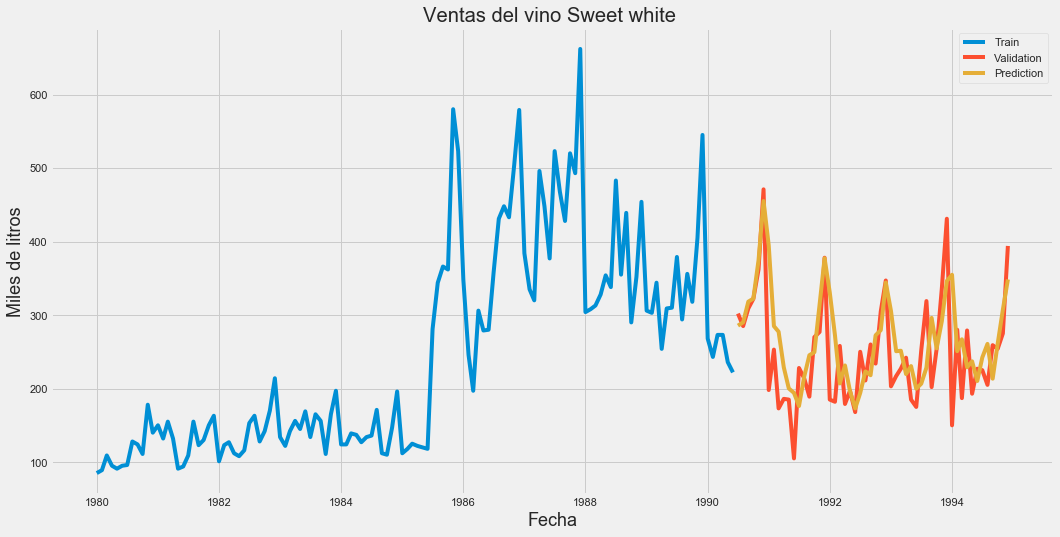

In [126]:
#Plot/Create the data for the graph
train = dfSweet[:training_data_len]
valid = dfSweet[training_data_len:]
valid['Predictions'] = predictions
#Visualize the data
plt.figure(figsize=(16,8))
plt.title('Ventas del vino Sweet white ')
plt.xlabel('Fecha', fontsize=18)
plt.ylabel('Miles de litros', fontsize=18)
plt.plot(train['Sweet white'])
plt.plot(valid[['Sweet white', 'Predictions']])
plt.legend(['Train', 'Validation', 'Prediction'], loc='upper right')
plt.show()

In [113]:
dataset = dfDry.values
#Get /Compute the number of rows to train the model on
training_data_len = math.ceil( len(dataset) *.7) 
#Scale the all of the data to be values between 0 and 1 
scaler = MinMaxScaler(feature_range=(0, 1)) 
scaled_data = scaler.fit_transform(dataset)
#Create the scaled training data set 
train_data = scaled_data[0:training_data_len  , : ]
#Split the data into x_train and y_train data sets
x_train=[]
y_train = []
for i in range(12,len(train_data)):
    x_train.append(train_data[i-12:i,0])
    y_train.append(train_data[i,0])
    

#Convert x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)
#Reshape the data into the shape accepted by the LSTM
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))
#Build the LSTM network model
model = Sequential()
model.add(Bidirectional(LSTM(units=50, return_sequences=True,input_shape=(x_train.shape[1],1))))
model.add(Bidirectional(LSTM(units=50, return_sequences=False)))
model.add(Dense(units=25))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [114]:
model.fit(x_train, y_train, batch_size=1, epochs=20)

Epoch 1/20
114/114 [==============================] - 35s 307ms/step - loss: 0.0318
Epoch 2/20
114/114 [==============================] - 10s 85ms/step - loss: 0.0233
Epoch 3/20
114/114 [==============================] - 9s 82ms/step - loss: 0.0173
Epoch 4/20
114/114 [==============================] - 9s 77ms/step - loss: 0.0135
Epoch 5/20
114/114 [==============================] - 8s 72ms/step - loss: 0.0124
Epoch 6/20
114/114 [==============================] - 8s 71ms/step - loss: 0.0100
Epoch 7/20
114/114 [==============================] - 8s 71ms/step - loss: 0.0113
Epoch 8/20
114/114 [==============================] - 8s 70ms/step - loss: 0.0107: 1s
Epoch 9/20
114/114 [==============================] - 9s 78ms/step - loss: 0.0113
Epoch 10/20
114/114 [==============================] - 9s 81ms/step - loss: 0.0113
Epoch 11/20
114/114 [==============================] - 9s 77ms/step - loss: 0.0111
Epoch 12/20
114/114 [==============================] - 9s 76ms/step - loss: 0.0112
Epoch 

In [115]:
#Test data set
test_data = scaled_data[training_data_len - 12: , : ]
#Create the x_test and y_test data sets
x_test = []
y_test =  dataset[training_data_len : , : ] #Get all of the rows from index 1603 to the rest and all of the columns (in this case it's only column 'Close'), so 2003 - 1603 = 400 rows of data
for i in range(12,len(test_data)):
    x_test.append(test_data[i-12:i,0])

In [116]:
#Convert x_test to a numpy array 
x_test = np.array(x_test)
#Reshape the data into the shape accepted by the LSTM
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))
#Getting the models predicted price values
predictions = model.predict(x_test) 
predictions = scaler.inverse_transform(predictions)#Undo scaling
#Calculate/Get the value of RMSE
rmse=np.sqrt(np.mean(((predictions- y_test)**2)))
rmse

542.8750384942745

B:\Anaconda\envs\hola\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


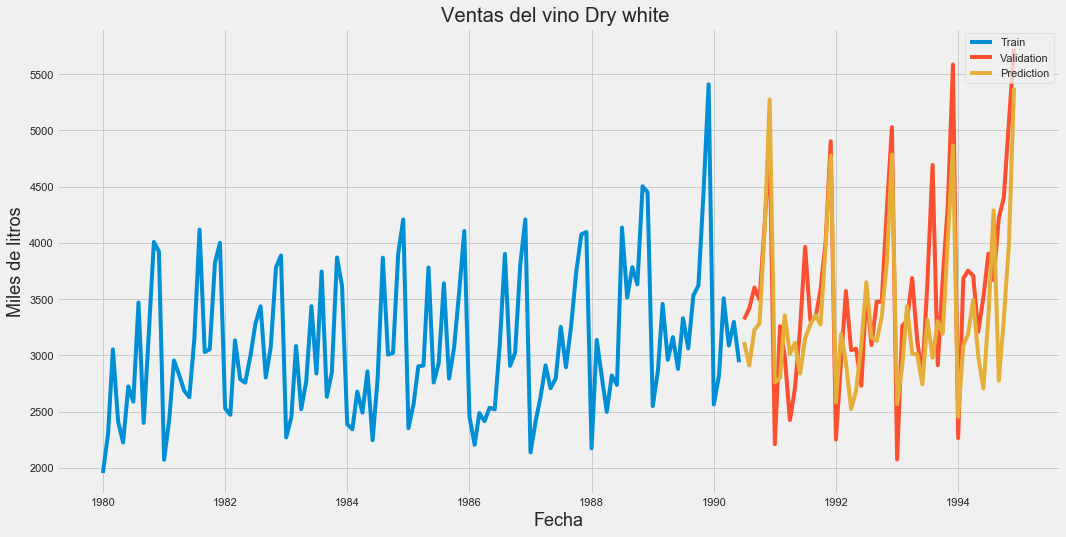

In [121]:
#Plot/Create the data for the graph
train = dfDry[:training_data_len]
valid = dfDry[training_data_len:]
valid['Predictions'] = predictions
#Visualize the data
plt.figure(figsize=(16,8))
plt.title('Ventas del vino Dry white ')
plt.xlabel('Fecha', fontsize=18)
plt.ylabel('Miles de litros', fontsize=18)
plt.plot(train['Dry white'])
plt.plot(valid[['Dry white', 'Predictions']])
plt.legend(['Train', 'Validation', 'Prediction'], loc='upper right')
plt.show()

# 2. Diseño de Experimentos (DoE) para mejorar los costos de producción de una empresa de manufactura que utiliza fibra sintética

### 2.1 Datos 

In [17]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats import anova
from statsmodels.formula.api import ols
import scipy.stats as stats
import seaborn as sns

In [18]:
data={'cotton':[15, 20, 25, 30, 35],
     'Obs1':[7, 12 ,14 , 19, 7],
     'Obs2':[7, 17 ,18 , 25, 10],
     'Obs3':[15, 12 ,18 , 22, 11],
     'Obs4':[22, 18 ,19 , 19, 15],
     'Obs5':[9, 18 ,19 , 23, 11]}
df = pd.DataFrame(data)
print(df)

   cotton  Obs1  Obs2  Obs3  Obs4  Obs5
0      15     7     7    15    22     9
1      20    12    17    12    18    18
2      25    14    18    18    19    19
3      30    19    25    22    19    23
4      35     7    10    11    15    11


In [19]:
df_tr=df.transpose()

In [20]:
df['Total']=[60, 77, 88, 108, 54 ]
df['Mean'] = [10,15.4, 17.6, 21.6 ,10.8]
df

,cotton,Obs1,Obs2,Obs3,Obs4,Obs5,Total,Mean
0,15,7,7,15,22,9,60,10.0
1,20,12,17,12,18,18,77,15.4
2,25,14,18,18,19,19,88,17.6
3,30,19,25,22,19,23,108,21.6
4,35,7,10,11,15,11,54,10.8


In [21]:
df_tr.columns = ['15%','20%','25%',  '30%','35%']
df_tr=df_tr.drop(['cotton'],axis=0)
df_tr

,15%,20%,25%,30%,35%
Obs1,7,12,14,19,7
Obs2,7,17,18,25,10
Obs3,15,12,18,22,11
Obs4,22,18,19,19,15
Obs5,9,18,19,23,11


Text(0, 0.5, 'Resistencia el material')

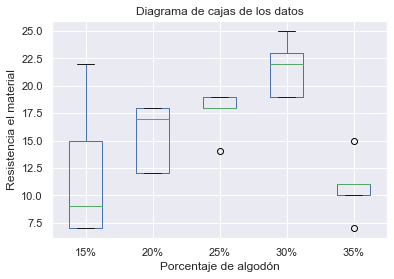

In [22]:
ax=df_tr.plot.box(grid='True',title='Diagrama de cajas de los datos')

ax.set_xlabel('Porcentaje de algodón')
ax.set_ylabel('Resistencia el material')

### 2.2 ANOVA

In [23]:
fvalue, pvalue = stats.f_oneway(df_tr['15%'], df_tr['20%'], df_tr['25%'], df_tr['30%'],df_tr['35%'])
print(fvalue, pvalue)

6.677918424753869 0.0013909531435422975


In [24]:
d_melt = pd.melt(df_tr.reset_index(), id_vars=['index'], value_vars=['15%', '20%', '25%', '30%','35%'])
d_melt.columns = ['index', 'treatments', 'value']
model = ols('value ~ C(treatments)', data=d_melt).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
C(treatments),379.84,4.0,6.677918,0.001391
Residual,284.40,20.0,NaN,NaN



### 2.3 [OPCIONAL] Prueba de comparaciones múltiples

In [25]:
newdf2=df_tr.drop(['25%','30%'],axis=1)
newdf2

,15%,20%,35%
Obs1,7,12,7
Obs2,7,17,10
Obs3,15,12,11
Obs4,22,18,15
Obs5,9,18,11


In [26]:
fvalue, pvalue = stats.f_oneway(newdf2['15%'], newdf2['20%'],newdf2['35%'])
print(fvalue, pvalue)

1.4233333333333333 0.2788134551728288


In [27]:
d_melt = pd.melt(newdf2.reset_index(), id_vars=['index'], value_vars=['15%', '20%','35%'])
d_melt.columns = ['index', 'treatments', 'value']
model = ols('value ~ C(treatments)', data=d_melt).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
C(treatments),56.933333,2.0,1.423333,0.278813
Residual,240.000000,12.0,NaN,NaN


In [28]:
newdf3=df_tr.drop(['15%','35%'],axis=1)
newdf3

,20%,25%,30%
Obs1,12,14,19
Obs2,17,18,25
Obs3,12,18,22
Obs4,18,19,19
Obs5,18,19,23


In [29]:
fvalue, pvalue = stats.f_oneway(newdf3['20%'], newdf3['25%'],newdf3['30%'])
print(fvalue, pvalue)

7.090909090909094 0.009270190538529333


In [30]:
d_melt = pd.melt(newdf3.reset_index(), id_vars=['index'], value_vars=['20%','25%', '30%'])
d_melt.columns = ['index', 'treatments', 'value']
model = ols('value ~ C(treatments)', data=d_melt).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
C(treatments),98.8,2.0,7.090909,0.00927
Residual,83.6,12.0,NaN,NaN
